In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut

from sklearn.cluster import KMeans

## Template Data Science -- Hands On Machine Learning

### Parte 2 - Regressão

### Dados

In [3]:
def data_info(data):        
    info = pd.DataFrame()
    info['var'] = data.columns
    info['# missing'] = list(data.isnull().sum())
    info['% missing'] = info['# missing'] / data.shape[0]
    info['types'] = list(data.dtypes)
    info['unique values'] = list(len(data[var].unique()) for var in data.columns)
    
    return info

#### Regressão

In [4]:
dataset = pd.read_csv('data/50_Startups.csv')

In [5]:
dataset.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [6]:
data_info(dataset)

,var,# missing,% missing,types,unique values
0,R&D Spend,0,0.0,float64,49
1,Administration,0,0.0,float64,50
2,Marketing Spend,0,0.0,float64,48
3,State,0,0.0,object,3
4,Profit,0,0.0,float64,50


### Preprocessing

In [9]:
X = pd.DataFrame(dataset.iloc[:, :4])
y = pd.DataFrame(dataset.iloc[:, -1])

In [10]:
X.head()

,R&D Spend,Administration,Marketing Spend,State
0,165349.20,136897.80,471784.10,New York
1,162597.70,151377.59,443898.53,California
2,153441.51,101145.55,407934.54,Florida
3,144372.41,118671.85,383199.62,New York
4,142107.34,91391.77,366168.42,Florida


#### Lidando com variáveis categóricas

Label Encoder: dá a cada elemento da variável categórica um número

    Uso: categóricas ordinais

In [11]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
X_le = X.copy()
for var in X.columns:
    if (X[var].dtype == object):
        X_le[var] = le.fit_transform(X[var])

One hot Encoder

In [12]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

le = LabelEncoder()
X_le = X.copy()
X_ohe = X.copy()
for var in X.columns:
    if (X[var].dtype == object):
        ohe = OneHotEncoder(categorical_features = [0])
        X_le[var] = le.fit_transform(X[var])
        X_ohe = ohe.fit_transform(X_le).toarray()

In [13]:
X_ohe = pd.DataFrame(X_ohe)

#### Padronização e Normalização

In [14]:
X_encoded = X_le

Normalização StandardScaler: remove a média de cada atributo e divide os atributos não-constantes pelo desvio padrão. Ex de uso: se um atributo cuja variância é MUITO maior do que do que dos outros atributos, este atributo pode dominar a função objetivo e impossibilitar o estimador de aprender com as outras features

In [15]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
std_scaler.fit(X_encoded)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [16]:
X_stds = pd.DataFrame(std_scaler.transform(X_encoded), columns = X_encoded.columns)

Normalização para intervalo: escalar os atributos para que seus valores fiquem dentro de um intervalo, dado o valor mínimo e o máximo

In [17]:
from sklearn.preprocessing import MinMaxScaler

minmaxscaler = MinMaxScaler()
minmaxscaler.fit(X_encoded)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [18]:
X_minmaxs = pd.DataFrame(minmaxscaler.transform(X_encoded), columns = X_encoded.columns)

Normalização Robust Scaler: Quando o dataset contém muitos outliers, usar média e variância não trará resultados bons. Usa uma estimativa mais robusta para encontrar o centro dos dados. Remove a mediana e escala os dados de acordo com os intervalos de quartis(intervalo interquartil (IQR): intervalo entre o primeiro quartil (25%) e o terceiro quartil (75%))

In [19]:
from sklearn.preprocessing import RobustScaler

robscaler = RobustScaler()
robscaler.fit(X_encoded)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [20]:
X_robusts = pd.DataFrame(robscaler.transform(X_encoded), columns = X_encoded.columns)

Normalização por sample (linha): cada registro/sample com pelo menos um componente não zero é reescalado independentemente dos outros samples

-l1-norm: divide cada elemento de cada sample pela soma dos módulos de cada elemento do tal sample

-l2-norm: divide cada elemento de cada sample pela raíz quadrada da soma dos quadrados de cada elemento de tal sample

In [21]:
from sklearn.preprocessing import Normalizer

nscaler = Normalizer(norm = 'l1')
nscaler.fit(X_encoded)

Normalizer(copy=True, norm='l1')

In [22]:
X_norm = pd.DataFrame(nscaler.transform(X_encoded), columns = X_encoded.columns)

#### Train Test Split

In [176]:
#escolha do X
X_preped = X_stds
#X_preped = X_le

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X_preped, y, test_size = 0.2, random_state = 0)

In [31]:
from sklearn.model_selection import StratifiedKFold, KFold, LeaveOneOut

cv_kfold = KFold(5, shuffle = False, random_state=12) #### se shuffle = False os k folds são sequenciais
cv_leave_one_out = LeaveOneOut()

### Modelagem -- Regressão

O modelo possui uma função com a cara $$y_{pred} = \beta_{0} + \beta_{1}*x$$

e devemos encontrar os coeficientes que minimizam a função de custo: $$Error = \sum_{i = 1}^{n}(y_i - y_{pred_{i}})$$



In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate

def reg_results_holdout(clf, X_train, y_train, X_test, y_test):
    
    classifier = clf.fit(X_train, np.ravel(y_train))
    metrics = [mean_squared_error, mean_absolute_error, r2_score ]
    
    pred_train = classifier.predict(X_train)
    pred_test = classifier.predict(X_test)

    results = pd.DataFrame()
    
    for m in metrics:
        result_train = m(y_train, pred_train)
        result_test = m(y_test, pred_test)
        
        dict_res = {'Treino': ["{:.3f}".format(result_train)], 'Teste': ["{:.3f}".format(result_test)]}
        res_aux = pd.DataFrame(dict_res, index = [str(m.__name__)])
        
        results = pd.concat([results, res_aux], axis = 0)
    
    return results

def reg_results_cv(clf, X_train, y_train, kcv):
    
    classifier = clf.fit(X_train, np.ravel(y_train))
    metrics = ['explained_variance', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_median_absolute_error', 'r2' ]
    
    results = pd.DataFrame()
    for m in metrics:
        cv_results = cross_validate(clf, X_train, np.ravel(y_train), scoring = m, cv = kcv, return_train_score = True)
        dict_res = {'' + m + '_Treino': cv_results['train_score'], 
                    '' + m + '_Teste': cv_results['test_score']}
        res_aux = pd.DataFrame(dict_res)
        results = pd.concat([results, res_aux], axis = 1)
        
    results_mean = np.transpose(pd.DataFrame(results.mean(), columns=['media']))
    results = pd.concat([results, results_mean], axis = 0)
    return results


def reg_grid_search(clf, X_train, y_train, params, score, cv):    
    grid = GridSearchCV(clf, params, scoring = score, cv = cv, return_train_score=True)
    grid_fitted = grid.fit(X_train, np.ravel(y_train))
    print ("Best score: %.4f" % grid_fitted.best_score_)
    print ("Best parameters: %s" % grid_fitted.best_params_)
    return grid_fitted, grid_fitted.best_estimator_, grid_fitted.cv_results_

#### Regressão Linear Simples -- Ordinary Least Squares (OLS)

In [33]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)

In [35]:
X_train.head()

,R&D Spend,Administration,Marketing Spend,State
33,55493.95,103057.49,214634.81,1
35,46014.02,85047.44,205517.64,2
26,75328.87,144135.98,134050.07,1
34,46426.07,157693.92,210797.67,0
18,91749.16,114175.79,294919.57,1


In [34]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [36]:
lin_reg.predict([[55490, 104050.6, 163948, 1]])

array([[94973.48038961]])

In [61]:
lin_reg.coef_

array([7.77203690e-01, 3.02432445e-02, 3.49236072e-02, 3.15877202e+02])

Holdout

In [37]:
reg_results_holdout(lin_reg, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,81871927.547,78413822.172
mean_absolute_error,6363.728,7400.616
r2_score,0.950,0.939


CV

In [112]:
reg_results_cv(lin_reg, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.960281,0.799559,-5994.896733,-9327.107673,-7.461256e+07,-1.350453e+08,-4370.189116,-6044.607778,0.960281,0.799415
1,0.953117,0.890455,-6636.851510,-7341.769460,-8.383498e+07,-9.889020e+07,-5769.035376,-4366.608750,0.953117,0.884967
2,0.961225,0.915799,-5900.599386,-8229.959941,-5.932795e+07,-1.797505e+08,-3758.358143,-4743.367970,0.961225,0.911925
3,0.949317,0.949026,-6693.286010,-6602.719145,-8.599677e+07,-7.208362e+07,-4942.683894,-5821.741009,0.949317,0.934704
4,0.929199,0.974223,-6338.398362,-7055.992131,-8.983680e+07,-8.018137e+07,-3771.013025,-4527.478872,0.929199,0.974217
media,0.950628,0.905812,-6312.806400,-7711.509670,-7.872181e+07,-1.131902e+08,-4522.255911,-5100.760876,0.950628,0.901045


#### l1 e l2

`l1`: Adiciona à função de custo um valor absoluto de magnitude dos coeficientes como uma penalidade
$$F_{cost} = \sum_{i = 1}^{n}(y_i - y_{pred_{i}}) + \lambda \sum_{j = 1}^{p}|\beta_j|$$
`l2`: Adiciona à função de custo um valor ao quadrado como penalidade
$$F_{cost} = \sum_{i = 1}^{n}(y_i - y_{pred_{i}}) + \lambda \sum_{j = 1}^{p}\beta_j^2$$

A norma l1 tem a capacidade de zerar coeficientes pela região em que intercepta as curvas $\beta$, enquanto a norma l2 diminui os coeficientes mas quase nunca zera.

<img src="l1_l2.png" width="400">

`Nota`: **Lasso** é um modelo que utiliza a norma l1 como penalização dos coeficientes e **Ridge** é um modelo que utiliza a norma l2 como penalização dos coeficientes

`Nota2`: As curvas de nível de $\beta$ representam uma distribuição normal em duas dimensões

##### Lasso

In [40]:
from sklearn.linear_model import Lasso
#alpha é o lambda  :P
#se alpha = 0, o modelo é equivalente ao OLS
lasso = Lasso(alpha=1.0, fit_intercept=True, normalize=False, precompute=False, copy_X=True, max_iter=1000, tol=0.0001, 
              warm_start=False, positive=False, random_state=None, selection='cyclic')

In [41]:
lasso.fit(X_train, y_train)

Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [42]:
lasso.predict([[55490, 104050.6, 163948, 1]])

array([94973.40252365])

In [44]:
#coeficientes do modelo linear
lasso.coef_

array([7.77210914e-01, 3.02394872e-02, 3.49226656e-02, 3.14483927e+02])

Holdout

In [49]:
reg_results_holdout(lasso, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,81871928.941,78409578.915
mean_absolute_error,6363.547,7400.263
r2_score,0.950,0.939


CV

In [54]:
reg_results_cv(lasso, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.960281,0.799580,-5995.127755,-9326.727466,-7.461257e+07,-1.350311e+08,-4369.811000,-6044.517151,0.960281,0.799436
1,0.953117,0.890481,-6636.670264,-7340.832735,-8.383498e+07,-9.886790e+07,-5769.919739,-4365.056802,0.953117,0.884993
2,0.961225,0.915803,-5900.715688,-8230.275844,-5.932795e+07,-1.797434e+08,-3758.395888,-4744.869898,0.961225,0.911928
3,0.949317,0.949031,-6693.014494,-6601.670245,-8.599678e+07,-7.207561e+07,-4942.248444,-5819.876883,0.949317,0.934711
4,0.929199,0.974227,-6338.701819,-7054.842046,-8.983680e+07,-8.016930e+07,-3771.095384,-4526.070776,0.929199,0.974221
media,0.950628,0.905824,-6312.846004,-7710.869667,-7.872182e+07,-1.131775e+08,-4522.294091,-5100.078302,0.950628,0.901058


##### Ridge

In [74]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0, fit_intercept=True, normalize=False, copy_X=True, max_iter=None, tol=0.001, solver='auto', 
              random_state=None)

In [75]:
ridge.fit(X_train, y_train)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [76]:
ridge.predict([[55490, 104050.6, 163948, 1]])

array([[94972.88593105]])

In [77]:
ridge.coef_

array([[7.77258802e-01, 3.02145889e-02, 3.49164259e-02, 3.05245020e+02]])

Holdout

In [78]:
reg_results_holdout(ridge, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,81872008.683,78381502.762
mean_absolute_error,6362.343,7397.918
r2_score,0.950,0.939


CV

In [80]:
reg_results_cv(ridge, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.960280,0.800175,-6001.766534,-9315.801360,-7.461370e+07,-1.346251e+08,-4358.943134,-6041.913114,0.960280,0.800039
1,0.953113,0.892227,-6624.587765,-7278.052389,-8.384174e+07,-9.738243e+07,-5805.083318,-4261.041581,0.953113,0.886721
2,0.961225,0.915829,-5901.484766,-8232.364633,-5.932804e+07,-1.796964e+08,-3758.645474,-4754.801510,0.961225,0.911951
3,0.949316,0.949181,-6684.881539,-6570.251944,-8.599820e+07,-7.183779e+07,-4929.204523,-5764.040497,0.949316,0.934927
4,0.929198,0.974296,-6344.131238,-7034.265889,-8.983730e+07,-7.995386e+07,-3772.569525,-4500.878077,0.929198,0.974290
media,0.950627,0.906342,-6311.370368,-7686.147243,-7.872380e+07,-1.126991e+08,-4524.889195,-5064.534956,0.950627,0.901585


##### Elastic Net

Combinação da norma l1 com a norma l2
$$J = MSE + a * l1 + (1-a) * l2$$

In [87]:
from sklearn.linear_model import ElasticNet
#se l1_ratio = 0, a norma é a l2
elastic = ElasticNet(alpha=1.0, l1_ratio=0.5, fit_intercept=True, normalize=False, precompute=False, max_iter=1000, copy_X=True, 
                     tol=0.0001, warm_start=False, positive=False, random_state=None, selection='cyclic')

In [88]:
elastic.fit(X_train, y_train)

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [89]:
elastic.predict([[55490, 104050.6, 163948, 1]])

array([94966.20585529])

In [90]:
elastic.coef_

array([7.77878112e-01, 2.98925769e-02, 3.48357278e-02, 1.85768305e+02])

Holdout

In [91]:
reg_results_holdout(elastic, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,81884077.657,78026839.429
mean_absolute_error,6346.780,7367.593
r2_score,0.950,0.939


CV

In [92]:
reg_results_cv(elastic, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.960219,0.805715,-6074.936267,-9212.389021,-7.472942e+07,-1.308543e+08,-4653.578968,-6126.480142,0.960219,0.805640
1,0.952764,0.906736,-6577.614293,-6725.524427,-8.446741e+07,-8.504714e+07,-5278.097973,-3345.606971,0.952764,0.901070
2,0.961220,0.916077,-5909.130637,-8253.130817,-5.933596e+07,-1.792396e+08,-3761.126781,-4853.538023,0.961220,0.912175
3,0.949239,0.950353,-6622.901644,-6335.825214,-8.612843e+07,-6.990634e+07,-4813.106567,-5267.065384,0.949239,0.936676
4,0.929160,0.974926,-6405.029251,-6842.847637,-8.988527e+07,-7.800173e+07,-3786.283001,-4266.512765,0.929160,0.974918
media,0.950520,0.910761,-6317.922418,-7473.943423,-7.890930e+07,-1.086098e+08,-4458.438658,-4771.840657,0.950520,0.906096


##### KNN Regressor

In [93]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', 
                          metric_params=None, n_jobs=1)

In [94]:
knn.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [95]:
knn.predict([[55490, 104050.6, 163948, 1]])

array([[89340.108]])

In [99]:
knn.kneighbors(X = [[55490, 104050.6, 163948, 1]], n_neighbors = 5)

(array([[29200.83389101, 31673.25980193, 32150.07309173, 36475.4905502 ,
         44942.70847292]]), array([[34, 22, 27, 14, 19]], dtype=int64))

Holdout

In [100]:
reg_results_holdout(knn, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,273641642.829,143358751.246
mean_absolute_error,11158.163,10447.029
r2_score,0.833,0.888


CV

In [102]:
reg_results_cv(knn, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.810671,0.781383,-13424.275875,-9968.38975,-3.596665e+08,-1.558132e+08,-9672.1190,-11534.948,0.808535,0.768568
1,0.799130,0.694946,-13499.132687,-12947.04500,-3.681115e+08,-2.627987e+08,-10180.7550,-12978.861,0.794142,0.694302
2,0.796876,0.753640,-12021.033312,-14450.67675,-3.111330e+08,-5.193477e+08,-8472.4130,-9556.672,0.796655,0.745527
3,0.815514,0.552854,-12289.699250,-18646.89075,-3.148965e+08,-5.755238e+08,-8902.9550,-16793.138,0.814413,0.478670
4,0.776433,0.605836,-11123.755562,-27744.09150,-2.875694e+08,-1.247983e+09,-5521.7150,-20316.456,0.773363,0.598697
media,0.799725,0.677732,-12471.579337,-16751.41875,-3.282754e+08,-5.522932e+08,-8549.9914,-14236.015,0.797422,0.657153


##### Árvore de Regressão

In [103]:
from sklearn.tree import DecisionTreeRegressor

#mse é a min variancia
tree = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                             min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, 
                             min_impurity_decrease=0.0, min_impurity_split=None, presort=False)

In [104]:
tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [121]:
tree.predict([[55490, 104050.6, 163948, 1]])

array([96778.92])

Importância das features

In [109]:
tree.feature_importances_

array([9.45408318e-01, 2.08054690e-03, 5.15938435e-02, 9.17291431e-04])

##### SVR

In [118]:
from sklearn.svm import SVR

svr = SVR(kernel='rbf', degree=3, gamma='auto', coef0=0.0, tol=0.001, C=1.0, epsilon=0.1, shrinking=True, cache_size=200, 
          verbose=False, max_iter=-1)

In [120]:
svr.fit(X_train, np.ravel(y_train))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [122]:
svr.predict([[55490, 104050.6, 163948, 1]])

array([107978.19])

Holdout

In [123]:
reg_results_holdout(svr, X_train, y_train, X_test, y_test)

,Treino,Teste
mean_squared_error,1639563313.149,1483359199.816
mean_absolute_error,31686.880,29316.979
r2_score,-0.001,-0.160


CV

In [124]:
reg_results_cv(svr, X_train, y_train, cv_kfold)

,explained_variance_Treino,explained_variance_Teste,neg_mean_absolute_error_Treino,neg_mean_absolute_error_Teste,neg_mean_squared_error_Treino,neg_mean_squared_error_Teste,neg_median_absolute_error_Treino,neg_median_absolute_error_Teste,r2_Treino,r2_Teste
0,0.000037,0.0,-34324.619063,-21159.66625,-1.879197e+09,-6.735195e+08,-29019.180,-13893.695,-0.000372,-0.000392
1,0.000038,0.0,-33766.783750,-23391.00750,-1.802261e+09,-9.812676e+08,-29019.180,-14782.545,-0.007873,-0.141451
2,0.000040,0.0,-30271.475312,-37414.88500,-1.541901e+09,-2.046041e+09,-21311.195,-33143.345,-0.007729,-0.002530
3,0.000039,0.0,-33009.910625,-27995.68125,-1.701653e+09,-1.565148e+09,-27889.755,-13040.425,-0.002886,-0.417768
4,0.000042,0.0,-26813.722500,-51180.50875,-1.270110e+09,-3.117480e+09,-18520.895,-50632.650,-0.000989,-0.002461
media,0.000039,0.0,-31637.302250,-32228.34975,-1.639025e+09,-1.676691e+09,-25152.041,-25098.532,-0.003970,-0.112920


`Nota`: a métrica $R^2$ só é negativa quando o modelo escolhido não segue o formato dos dados, fitando pior que uma linha horizontal

ex:

<img src="negr2.png" width="200">

## Tópico extra: PCA (Principal Component Analysis)

`Nota`: Funciona só com variável numérica

`Nota2`: PCA é muito sensível a escala. Normalize!

In [180]:
from sklearn.decomposition import PCA

In [232]:
pca = PCA(n_components=2, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', random_state=None)

In [233]:
#normalização
X_train_norm = X_train

In [234]:
principal_components = pca.fit_transform(X_train_norm)

In [235]:
X_train_pca = pd.DataFrame(data = principal_components, columns = ['pc1', 'pc2'])

In [236]:
X_train_pca.head()

,pc1,pc2
0,-0.355420,0.248465
1,-0.422932,1.589381
2,-0.091693,-0.036364
3,-0.289846,-1.329516
4,0.717452,-0.030988


In [237]:
#porcentagem de explicabilidade
pca.explained_variance_ratio_

array([0.47502984, 0.26191411])

Visualização

In [187]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [239]:
sns.set_context("notebook", font_scale=1.1)
sns.set_style("ticks")

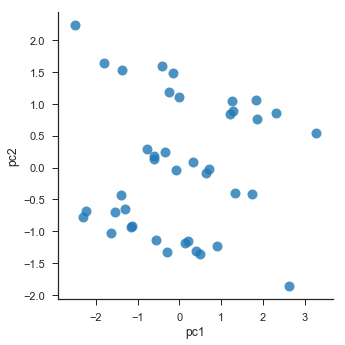

In [241]:
sns.lmplot('pc1', 'pc2', X_train_pca, fit_reg=False, scatter_kws={"marker": "D","s": 100})